In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# import packages
import json
import os 
import tensorflow as tf
import sklearn
import seaborn as sbs
import sklearn.naive_bayes 
import sklearn.model_selection
import sklearn.metrics
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Comments.csv")
df= df.head(25000)
# df=df.reset_index()
df

,learner_id,step,text,timestamp,likes,word_count,char_count,SA,completed
0,00000007c103,2.80,interesting and useful !,15/03/2015 7:07,1,4,24,1,1
1,00000007c103,2.80,I totally learned web development !!!Great Lec...,16/03/2015 5:49,0,7,52,1,1
2,00000007c103,5.11,Very clear concise and simple explanation,02/04/2015 3:15,0,6,41,1,1
3,000046e8f020,2.10,Great course. Jogesh has done wonderful job in...,14/11/2015 20:53,2,13,80,1,1
4,00006b585440,5.11,Perfect introduction course to Big Data,02/12/2015 10:36,1,6,39,1,1
...,...,...,...,...,...,...,...,...,...
24995,314ea16d52e1,3.70,Great course for understanding the fundamentals.,01/04/2014 14:38,2,6,48,1,0
24996,314ea16d52e1,3.90,I liked the course very much. For a foreign sp...,02/04/2014 18:32,1,133,764,1,0
24997,314ea16d52e1,3.10,One of the best classes in Coursera.I heard ab...,02/04/2014 18:55,0,61,304,1,0
24998,314ea16d52e1,3.13,Great class for the content I needed. I audite...,02/04/2014 19:19,0,34,200,1,0


In [ ]:
df.completed.value_counts(normalize=True), df.completed.value_counts()

(1    0.55548
 0    0.44452
 Name: completed, dtype: float64, 1    13887
 0    11113
 Name: completed, dtype: int64)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'completed')

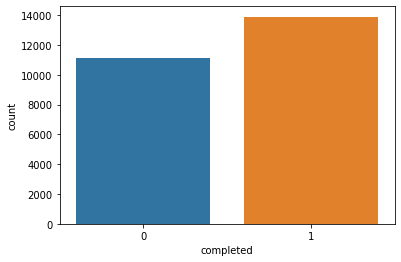

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(df.completed)
plt.xlabel('completed')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


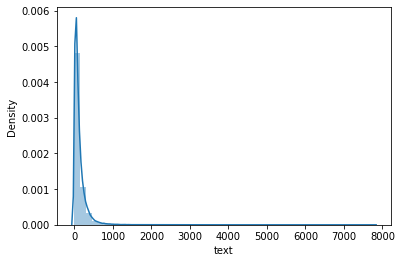

In [ ]:
# A birdview of headline length. Seems the majority has a length of 70, that's about 5 to 15 words, which makes sence.
sbs.distplot(df.text.str.len())

In [ ]:

# %%time
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece
import tensorflow_hub as hub 
import tokenization

module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
import numpy as np
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu',  kernel_regularizer='l1')(clf_output)
    net = tf.keras.layers.Dropout(0.9)(net)
    net = tf.keras.layers.Dense(32, activation='relu',  kernel_regularizer='l1')(net)
    net = tf.keras.layers.Dropout(0.9)(net)
    net = tf.keras.layers.Dense(16, activation='relu',  kernel_regularizer='l1')(net)
    net = tf.keras.layers.Dropout(0.9)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    # opt = tf.keras.optimizers.Adam(lr=1e-2)
    opt1 = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [ ]:
df=df.dropna()
max_len = 100
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(df.text, df['completed'],test_size=0.3, random_state=0)
X_train = bert_encode(X_train, tokenizer, max_len=max_len)
X_val = bert_encode(X_val, tokenizer, max_len=max_len)


In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/bertmodel_50000.h5',
    monitor='val_accuracy', 
    save_best_only=False, 
    verbose=0,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
train_history = model.fit(X_train, y_train, 
    # validation_split=0.1,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[checkpoint],
    batch_size=64,
    verbose=1)


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
# %%time

from sklearn.metrics import recall_score

# model.load_weights('/content/drive/MyDrive/Colab Notebooks/bertmodel20000.h5') # 4000
# model.load_weights('/content/drive/MyDrive/Colab Notebooks/bertmodel_40000_20000.h5')# 40000+30000
y_preds = model.predict(X_val).round().astype(int)
print("Validation accuracy: ", sklearn.metrics.accuracy_score(y_val, y_preds))


In [ ]:
print(recall_score(y_val, y_preds, average='macro'))
print(recall_score(y_val, y_preds, average='micro'))
print(recall_score(y_val, y_preds, average='weighted'))
print(recall_score(y_val, y_preds, average=None))

In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
average_precision = average_precision_score(y_val, y_preds)
print(recall_score(y_val, y_preds, average='macro'))
print(accuracy_score(y_val, y_preds))
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_val, y_preds, average='macro')